#### pip install opencv-python
#### pip install opencv-contrib-python
#### pip install imutils

#### OpenCV center of contour --> https://www.pyimagesearch.com/2016/02/01/opencv-center-of-contour/

#### PyTesseract: Simple Python Optical Character Recognition --> https://stackabuse.com/pytesseract-simple-python-optical-character-recognition


# Import necessary libraries

In [1]:
# Import OpenCV library to perform image processing
import cv2

# Import imutils to make basic image processing functions such as sorting contours
import imutils

# Import NumPy library for working with arrays
import numpy as np

# Import PyTesseract library to detect characters from images 
import pytesseract

# Import matplotlib library to plot graph
import matplotlib.pyplot as plt

# Import OS module to interact with the file system
import os

## Read CSV File

In [2]:
# Import Pandas library to read csv file
import pandas as pd

# Assign the file name
file_name = 'Car_Plate_Dataset.csv'

# Read the csv file
df = pd.read_csv(file_name)

# Show the first 5 row of the dataset
df.head()

,Image,Correct_Car_Plate,Detected_Result,C_len,CChar_len,CDigits_len,DR_len,DRChar_len,DRDigits_len,Label
0,images//carplate1.jpg,MAH41,MAH41,5,3,2,5,3,2,1
1,images//carplate2.jpg,WYK7460,0,7,3,4,0,0,0,2
2,images//carplate4.jpg,PKV8098,PKV09809,7,3,4,8,3,5,0
3,images//carplate5.jpg,UTM9999,0,7,3,4,0,0,0,2
4,images//carplate6.jpg,BJY6688,BJY6688,7,3,4,7,3,4,1


## Read Image from File

images//carplate3.jpg


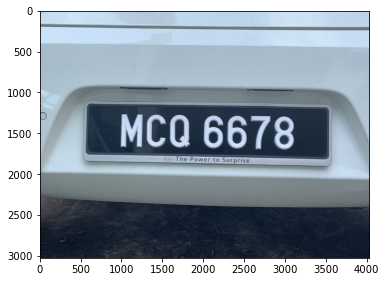

In [3]:
# Assign the path to the file
imdir = 'images'

# Get the total number of images
totalImages = len(os.listdir(imdir))

# Create a variable to store the first image number
num = 1

# Loop to read all the images
while num <= totalImages:
    # Create a variable to store the image name
    img_name = imdir + '//carplate' + str(num) + '.jpg'
        
    # Check whether the image has recorded into the csv file or not
    searchImg = df["Image"].str.contains(img_name)
        
    # If the image is do not exist in the csv file, print the image name
    if searchImg.any() == False and num <= totalImages:
        
        # Print the image path
        print(img_name)
        
        # Read the image
        img = cv2.imread(img_name,cv2.IMREAD_COLOR)  
        
        # Convert the image to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Create a new figure with 10 inches width and 10 inches height
        fig = plt.figure(figsize=(10,10)) 
        
        # Add an Axes to the figure as part of a subplot arrangement
        ax = fig.add_subplot(211)
        
        # Show the image
        ax.imshow(img)
        break
    else:
        # Change the image number
        num += 1

# If all the images have been detected
if num > totalImages:
    # Ask user to insert new image
    print("Please insert a new image")

# Image Preprocessing

## Resize Image and Convert to grayscale image

In [4]:
# Resize the image to the required size
img = cv2.resize(img, (600,400))

# Convert the resized colour image to grayscale image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

# Show the image
cv2.imshow('picGray',gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Image denoise

In [5]:
# Remove the unwanted noise from the image
filterImg = cv2.bilateralFilter(gray, 13, 15, 15)

# Show the image
cv2.imshow('Image after filter',filterImg)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Feature Extraction
## Edge detection

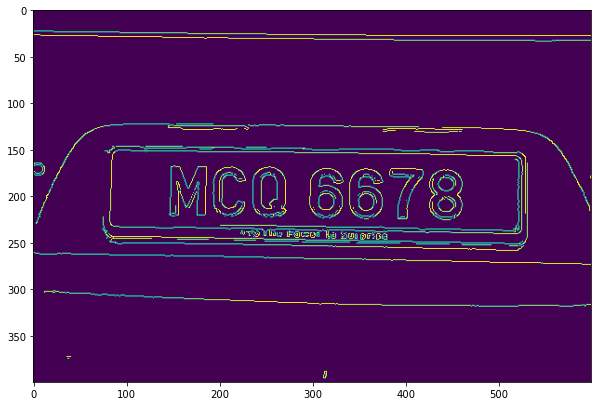

In [6]:
# Detect edge using Canny operator
edged = cv2.Canny(filterImg, 30, 200) 

# Show the edged image
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(211)
ax.imshow(edged)

## Contour detection

In [7]:
# Find contours from the edged image
contours = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Return the actual contours array
contours = imutils.grab_contours(contours)

# Sort from big to small
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]

In [8]:
# Create a variable to check number of the approximated contour
screenCnt = None

# Loop over the contours
for c in contours:
    # Approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.018 * peri, True)
    
    # Check whether the approximated contour has 4 points or not
    if len(approx) == 4:
        screenCnt = approx
        break
        
# If the contour is not found then display the message
if screenCnt is None:
    detected = 0
    print ("No contour detected")
else:
     detected = 1 # If the contour is found

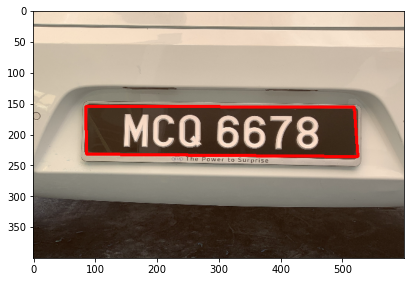

In [9]:
# If the contour is found
if detected == 1:
    
    # Draw a rectangle box around the car plate
    # Draw the contour and center of the shape on the image
    cv2.drawContours(img, [screenCnt], -1, (0, 0, 255), 3)
    
    # Show the image output
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(211)
    ax.imshow(img)

# Character Segmentation
##### To segment the car plate out of the image by cropping it and saving it as a new image

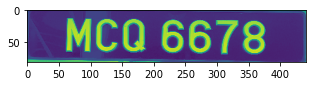

In [10]:
# If the couter is found
if detected == 1:
    
    # Mask the part other than the number plate
    mask = np.zeros(gray.shape,np.uint8)
    
    # Draw the contour and center of the shape on the image
    new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)
    
    # Take only the region of the car plate from the image
    new_image = cv2.bitwise_and(img,img,mask=mask)
    
    # Crop the image
    (x, y) = np.where(mask == 255)
    (topx, topy) = (np.min(x), np.min(y))
    (bottomx, bottomy) = (np.max(x), np.max(y))
    Cropped = gray[topx:bottomx+1, topy:bottomy+1]
    
    # Show the image output
    fig = plt.figure(figsize=(5,10))
    ax = fig.add_subplot(212)
    ax.imshow(Cropped)

# Character Recognition

In [11]:
# If the couter is found
if detected == 1:
    # Read the characters from image by using PyTesseract package
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    text = pytesseract.image_to_string(Cropped, config='--psm 11')
    print("Detected car plate number is:",text)

Detected car plate number is: MCQ 6678 |



## Remove the symbols

In [12]:
# Create a function to extract upper case characters
def get_upper(str1):
    output_char = ""
    for char in str1:
        if char.isupper():
            output_char += char
    return output_char

# Create a function to extract the digit numbers
def get_digits(str2):
    output_digit = ""
    for i in str2:
        if i.isdigit():
            output_digit += i
    return output_digit

In [13]:
# If the couter is found
if detected == 1:
    
    # Store the upper case characters into a new variable
    characters = get_upper(text)
    if characters == "":
        # Assign 0 into characters 
        characters = "0"
        
        # Print the result
        print("Detected characters: Null")
    else:
        # Print the characters 
        print("Detected uppercase characters: " + characters)
    
    
    # Store the numbers into a new variable
    digits = get_digits(text)
    # If digits is not detected
    if digits == "" or digits == 0:
        # Assign 0 into digits 
        digits = 0
        
        # Print the result
        print("Detected numbers: Null")
        
        # Only characters will be assigned into result
        result = characters
        
        # Print the result
        print("Car plate: " + result)
    else:
        # Print the numbers
        print("Detected numbers: " + digits)
        
        # Assign the characters and numbers into result
        result = characters + digits 
        
        # Print the result
        print("Car plate: " + result)

Detected uppercase characters: MCQ
Detected numbers: 6678
Car plate: MCQ6678


## Read User Input

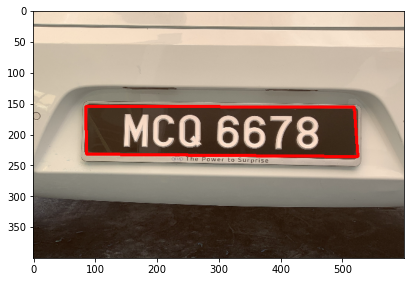

In [14]:
# Show the image again
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
ax.imshow(img)

In [15]:
# Get the user input to store the correct car plate
answer = input("Enter the correct car plate: ")

# Store the upper case characters into a new variable
Ans_char = get_upper(answer.upper())

# Print the characters 
print("Characters: " + Ans_char.upper())

# Store the numbers into a new variable
Ans_digits = get_digits(answer)

# Print the numbers
print("Numbers: " + Ans_digits)

Enter the correct car plate: MCQ6678
Characters: MCQ
Numbers: 6678


### Assign label

In [16]:
# If the couter is found
if detected == 1:
    
    # Compare the detected result with the user input
    # If match, the label will be value 1
    if answer.upper() == result:
        label = 1
        print("True")
    else:
        # Not match
        label = 0
        print("False")

True


In [17]:
# If the couter is not found
if detected == 0:
    label = 2
    print("No contour detected")

# Write in CSV file

In [18]:
# Import DictWriter function from CSV module
from csv import DictWriter

# Assign the file name 
file_name = 'Car_Plate_Dataset.csv'

# Assign the field names for the file
field_names = ['Image','Correct_Car_Plate', 'Detected_Result', 'C_len', 'CChar_len', 'CDigits_len', 'DR_len', 'DRChar_len', 'DRDigits_len', 'Label']

# Create a function to open file in append mode
def append_dict_as_row(file_name, dict_of_elem, field_names):
    
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        
        # Create a writer object from csv module
        dict_writer = DictWriter(write_obj, fieldnames=field_names)
        
        # Add dictionary as row in the csv
        dict_writer.writerow(dict_of_elem)

In [19]:
# If the couter is found and the detected car plate is correct, store the label value as 1
if detected == 1 and label == 1:
    
    # Assign the variables by the field names and store it into a new variable  
    row_dict = {'Image': img_name,'Correct_Car_Plate': answer.upper(), 'Detected_Result': result, 'C_len': len(answer), 'CChar_len': len(Ans_char), 'CDigits_len': len(Ans_digits), 'DR_len': len(result), 'DRChar_len': len(characters), 'DRDigits_len': len(digits), 'Label': label}
    
    # Append a dict as a row in csv file
    append_dict_as_row(file_name, row_dict, field_names)

In [20]:
# If the counter is found but car plate numbers are wrong, store the results and label is stored as 0
if detected == 1 and label == 0:
    
    if digits == 0:
        dig = 0
    else:
        dig = len(digits)
        
    if characters == "0":
        char = 0
    else:
        char = len(characters)
    
    if result == "0":
        DRresult = 0
    else:
        DRresult = len(result)
    
    # Assign the variables by the field names and store it into a new variable         
    row_dict = {'Image': img_name,'Correct_Car_Plate': answer.upper(), 'Detected_Result': result, 'C_len': len(answer), 'CChar_len': len(Ans_char), 'CDigits_len': len(Ans_digits), 'DR_len': DRresult, 'DRChar_len': char, 'DRDigits_len': dig, 'Label': label}
    
    # Append a dict as a row in csv file
    append_dict_as_row(file_name, row_dict, field_names)

In [21]:
# If the counter is not found, store value 0 for each feature and label is stored as 2
if detected == 0 and label == 2:
    
    # Assign the variables by the field names and store it into a new variable         
    row_dict = {'Image': img_name,'Correct_Car_Plate': answer.upper(), 'Detected_Result': detected, 'C_len': len(answer), 'CChar_len': len(Ans_char), 'CDigits_len': len(Ans_digits), 'DR_len': detected, 'DRChar_len': detected, 'DRDigits_len': detected, 'Label': label}
    
    # Append a dict as a row in csv file
    append_dict_as_row(file_name, row_dict, field_names)

In [22]:
# Import Pandas library to read csv file
import pandas as pd

# Assign the file name
file_name = 'Car_Plate_Dataset.csv'

# Read the csv file
df = pd.read_csv(file_name)

# Display the total number of records
total = len(df)
print("Total records:", total)

# Display the data frame
df

Total records: 30


,Image,Correct_Car_Plate,Detected_Result,C_len,CChar_len,CDigits_len,DR_len,DRChar_len,DRDigits_len,Label
0,images//carplate1.jpg,MAH41,MAH41,5,3,2,5,3,2,1
1,images//carplate2.jpg,WYK7460,0,7,3,4,0,0,0,2
2,images//carplate4.jpg,PKV8098,PKV09809,7,3,4,8,3,5,0
3,images//carplate5.jpg,UTM9999,0,7,3,4,0,0,0,2
4,images//carplate6.jpg,BJY6688,BJY6688,7,3,4,7,3,4,1
5,images//carplate7.jpg,WTF6075,0,7,3,4,0,0,0,2
6,images//carplate8.jpg,DEB70,DEB70,5,3,2,5,3,2,1
7,images//carplate9.jpg,PPP1,0,4,3,1,0,0,0,2
8,images//carplate10.jpg,BJH8918,BJH8918,7,3,4,7,3,4,1
9,images//carplate11.jpg,BPW96,BPWSE,5,3,2,5,5,0,0


## Search function

In [25]:
# Create a search function
def searchCarPlate(userInput):
    
    # Find the car plate from the dataset
    # If the car plate doesn't exist inside the dataset, it returns False
    # else it return True
    searchResult = df["Correct_Car_Plate"].str.contains(userInput)
    print(searchResult)
    
    # If the car plate is found, print the message
    if searchResult.any() == True:
        print("\nFound the car plate from dataset: ", userInput)
        
        # Display the content of the car plate found from dataset
        content = df.loc[df["Correct_Car_Plate"].str.contains(userInput)]
        print(content.to_string())
    else:
        print("\nNot Found")

In [26]:
e = 1

# If the user inpur is invalid, then loop 
while e == 1:
    # Ask the user whether to search or not
    yesNo = input("Do you want to search? (Yes = Y / No = N): ")
    
    # If the user wants to search
    if yesNo.upper() == "Y":
        
        cont = "Y"
        # If the user wants to search again, then loop
        while cont == "Y":
            # Get the input to search
            userSearch = input("Enter the number of car plate to search: ")
            
            # Convert the user input to upper case characters
            userSearch = userSearch.upper()
            
            # Call the search function
            searchCarPlate(userSearch)
            
            # Ask user whether continue to search or not
            cont = input("Continue to search? (Yes = Y / No = any key): ")
            
            # Convert the user input to upper case characters
            cont = cont.upper()
            
            # If the user dont want to search again
            if cont != "Y":
                print("Cancelled to search")
                e = 0
            
    elif yesNo.upper() == "N":
        print("Cancelled to search")
        e = 0
    else:
        print("Invalid input. Please try again.")
        e = 1

Do you want to search? (Yes = Y / No = N): i
Invalid input. Please try again.
Do you want to search? (Yes = Y / No = N): y
Enter the number of car plate to search: MCQ6678
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29     True
Name: Correct_Car_Plate, dtype: bool

Found the car plate from dataset:  MCQ6678
                    Image Correct_Car_Plate Detected_Result  C_len  CChar_len  CDigits_len  DR_len  DRChar_len  DRDigits_len  Label
29  images//carplate3.jpg           MCQ6678         MCQ6678      7          3            4       7           3             4      1
Continue to search? (Yes = Y / No = any key): m
Cancelled to search


## User Interface
### using Anvil web app

In [ ]:
# Import Pandas library to read csv file
import pandas as pd

# Assign the file name
file_name = 'Car_Plate_Dataset.csv'

# Read the csv file
df = pd.read_csv(file_name)

In [ ]:
# Create search function
def search(text):
    searchResult = df["Correct_Car_Plate"].str.contains(text)
    if searchResult.any() == True:
        content = df.loc[df["Correct_Car_Plate"].str.contains(text)]
        return(content.to_string())
    else:
        return("Not Found")

def showLabel(text):
    searchResult = df["Correct_Car_Plate"].str.contains(text)
    if searchResult.any() == True:
        content = df.loc[df["Correct_Car_Plate"].str.contains(text)]
        label = content.drop(['Correct_Car_Plate', 'Detected_Result', 'C_len', 'CChar_len', 'CDigits_len', 'DR_len', 'DRChar_len', 'DRDigits_len', 'Image'], axis=1)
        return(label.to_string())

In [ ]:
import anvil.server

anvil.server.connect("TV6GWQ5EDAA7T75GASFXLHPB-TK7OCK5FNBQEHMY4")

In [ ]:
import numpy as np
import anvil.media
from keras.preprocessing import image

@anvil.server.callable
def searchCarPlate(text):
    result = search(text.upper())
    return(result)

@anvil.server.callable
def label(text):
    label = showLabel(text.upper())
    dec = "Note:\n 0 = False \n 1 = True \n 2 = No contour detected"
    return(dec,label)
    
@anvil.server.callable    
def classify_image(file):
    with anvil.media.TempFile(file) as filename:
        img = image.load_img(filename)
    
    arr = image.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr /= 255.0
    img1 = Image.open(r"Untitled Folder//carplate19.jpg")
    img1 = img1.save("images//carplate31.jpg")
    result = "The image is uploaded"
    return(result)

# Training Model

In [5]:
# Import Pandas library to read csv file
import pandas as pd

# Assign the csv file name
file_name = 'Car_Plate_Dataset.csv'

# Read the csv file
df = pd.read_csv(file_name)

# Show the first 5 rows of data frame
df.head()

,Image,Correct_Car_Plate,Detected_Result,C_len,CChar_len,CDigits_len,DR_len,DRChar_len,DRDigits_len,Label
0,images//carplate1.jpg,MAH41,MAH41,5,3,2,5,3,2,1
1,images//carplate2.jpg,WYK7460,0,7,3,4,0,0,0,2
2,images//carplate3.jpg,MCQ6678,MCQ6678,7,3,4,7,3,4,1
3,images//carplate4.jpg,PKV8098,PKV09809,7,3,4,8,3,5,0
4,images//carplate5.jpg,UTM9999,0,7,3,4,0,0,0,2


In [6]:
# Check whether the data frame has any missing value
df.isnull().values.any()

False

Distributions of the Labels
2    10
1    10
0    10
Name: Label, dtype: int64


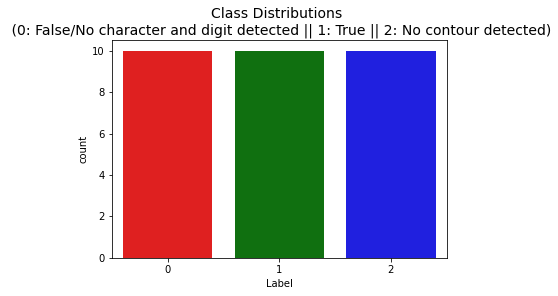

In [7]:
# Import Seaborn library for statistical graphics plotting
import seaborn as sns

# Import Matplotlib library to plot graph
import matplotlib.pyplot as plt

# Import Warnings to filter the warnings message
import warnings
warnings.filterwarnings("ignore")

# Display the counts of each label
print('Distributions of the Labels')
print(df.Label.value_counts())

# Assign the colour for the bar chart
colours = ['r','g', 'b']

# Show the counts of each class using bars
sns.countplot('Label', data=df, palette=colours)

# Set the title for the chart
plt.title('Class Distributions \n (0: False/No character and digit detected || 1: True || 2: No contour detected)', fontsize=14)

# Show the plot
plt.show()

In [8]:
# Drop the Label column and Image column
# Assign other columns to X
#X = df.drop(['Label', 'Image', 'Correct_Car_Plate', 'Detected_Result'], axis=1) # inputs into model
X = df.drop(['Label', 'Image'], axis=1) # inputs into model

# Assign the Label column to y
y = df['Label'] # output of model

# Show the first 5 rows of X 
X.head()

,Correct_Car_Plate,Detected_Result,C_len,CChar_len,CDigits_len,DR_len,DRChar_len,DRDigits_len
0,MAH41,MAH41,5,3,2,5,3,2
1,WYK7460,0,7,3,4,0,0,0
2,MCQ6678,MCQ6678,7,3,4,7,3,4
3,PKV8098,PKV09809,7,3,4,8,3,5
4,UTM9999,0,7,3,4,0,0,0


In [9]:
# Assign the Correct_Car_Plate column into A
A = df.Correct_Car_Plate

A.head()

0      MAH41
1    WYK7460
2    MCQ6678
3    PKV8098
4    UTM9999
Name: Correct_Car_Plate, dtype: object

In [10]:
# Assign the Detected_Result column into B
B = df.Detected_Result

B.head()

0       MAH41
1           0
2     MCQ6678
3    PKV09809
4           0
Name: Detected_Result, dtype: object

## Vectorize the feature

In [11]:
# Import CountVectorizer function to convert the data to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer

# Import Pandas library
import pandas as pd

# Assign CountVectorizer function into cv and the feature should be character or digit
cv = CountVectorizer(analyzer='char')

# Use fit_transform() function with the Correct_Car_Plate column
A_cv = cv.fit_transform(A)

# Print the dimensions 
print(A_cv.toarray().shape)

# Assign the array into the data frame format
A_cv_df  = pd.DataFrame(A_cv.toarray(), columns=cv.get_feature_names())

# Print the result
A_cv_df 

(30, 33)


,0,1,2,3,4,5,6,7,8,9,...,n,p,q,r,s,t,u,v,w,y
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,2,1,1,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,2,1,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,1,1,0,0,0
5,0,0,0,0,0,0,2,0,2,0,...,0,0,0,0,0,0,0,0,0,1
6,1,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,1,0,0,1,0
7,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Import CountVectorizer function
from sklearn.feature_extraction.text import CountVectorizer

# Assign CountVectorizer function into cv
cv = CountVectorizer(analyzer='char')

# Use fit_transform() function with the Detected_Result column
B_cv = cv.fit_transform(B)

# Print the dimensions 
print(B_cv.toarray().shape)

# Assign the array into the data frame format
B_cv_df = pd.DataFrame(B_cv.toarray(), columns=cv.get_feature_names())

# Print the result
B_cv_df

(30, 28)


,0,1,2,3,4,5,6,7,8,9,...,j,k,m,n,p,q,s,v,w,y
0,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,2,1,1,0,...,0,0,1,0,0,1,0,0,0,0
3,2,0,0,0,0,0,0,0,1,2,...,0,1,0,0,1,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,2,0,2,0,...,1,0,0,0,0,0,0,0,0,1
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,2,1,...,1,0,0,0,0,0,0,0,0,0


## Combine data frames

In [13]:
# Use the concat function to combine both data frames by following the index 
X_cv = pd.concat([A_cv_df , B_cv_df.reindex(A_cv_df .index)], axis=1)

# Drop the Label, Image, Correct_Car_Plate, and Detected_Result rows
C_df = df.drop(['Label', 'Image', 'Correct_Car_Plate', 'Detected_Result'], axis=1)

# Combine the data frames
X_cv = pd.concat([X_cv , C_df.reindex(X_cv.index)], axis=1)

# Print the result
X_cv

,0,1,2,3,4,5,6,7,8,9,...,s,v,w,y,C_len,CChar_len,CDigits_len,DR_len,DRChar_len,DRDigits_len
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,5,3,2,5,3,2
1,1,0,0,0,1,0,1,1,0,0,...,0,0,0,0,7,3,4,0,0,0
2,0,0,0,0,0,0,2,1,1,0,...,0,0,0,0,7,3,4,7,3,4
3,1,0,0,0,0,0,0,0,2,1,...,0,1,0,0,7,3,4,8,3,5
4,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,7,3,4,0,0,0
5,0,0,0,0,0,0,2,0,2,0,...,0,0,0,1,7,3,4,7,3,4
6,1,0,0,0,0,1,1,1,0,0,...,0,0,0,0,7,3,4,0,0,0
7,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,5,3,2,5,3,2
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,4,3,1,0,0,0
9,0,1,0,0,0,0,0,0,2,1,...,0,0,0,0,7,3,4,7,3,4


# Split the data
### 70% training set and 30% test set

In [70]:
# Import train_test_split function to split the data
from sklearn.model_selection import train_test_split

# Split the data into training set and test set
# 70% training set and 30% test set
# Random state = 42 to get the same random train / test split
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X_cv, y, test_size=0.3, random_state=42)

# Print the length of each sets
print("X_train_70: ", X_train_70.shape)
print("X_test_30: ", X_test_30.shape)
print("y_train_70: ", len(y_train_70))
print("y_test_30: ", len(y_test_30))

X_train_70:  (21, 67)
X_test_30:  (9, 67)
y_train_70:  21
y_test_30:  9


In [71]:
# Convert y_train_70 to list and assign it into labels_train_70
labels_train_70 = y_train_70.tolist()

# Print the content of list
print(labels_train_70)

# Display the length
len(labels_train_70)

[1, 2, 1, 1, 2, 2, 0, 2, 1, 0, 0, 2, 0, 0, 2, 1, 1, 0, 0, 1, 2]


21

# K- Means model

In [72]:
# Import KMeans
from sklearn.cluster import KMeans

# Create a KMeans instance with 3 clusters: model
km = KMeans(n_clusters=3)

# Fit model to X_train_70
km.fit(X_train_70)

# Determine the cluster labels of new_points: labels
labels = km.labels_

# Print cluster labels of new_points
print(labels)

# Print the length
len(labels)

[2 0 1 1 0 0 1 0 1 1 1 0 1 2 0 1 2 2 1 2 0]


21

In [79]:
# Use fit_predict function to fit model and obtain cluster labels: km_labels
km_labels = km.fit_predict(X_train_70)

# Create a DataFrame with labels and varieties as columns: df
df = pd.DataFrame({'km_labels': km_labels, 'dataset_labels': labels_train_70})

# Create crosstab and assign it as ct 
# To compare resulting cluster labels with user-defined labels
ct = pd.crosstab(df['km_labels'], df['dataset_labels'])

# Print the data frame
print(df.to_string())

    km_labels  dataset_labels
0           0               1
1           2               2
2           1               1
3           1               1
4           2               2
5           2               2
6           1               0
7           2               2
8           1               1
9           1               0
10          1               0
11          2               2
12          1               0
13          0               0
14          2               2
15          1               1
16          0               1
17          0               0
18          1               0
19          0               1
20          2               2


In [80]:
# Print crosstab
print(ct)

dataset_labels  0  1  2
km_labels              
0               2  3  0
1               5  4  0
2               0  0  7


Text(0.5, 1.0, 'Heat Map of K-Means Modul')

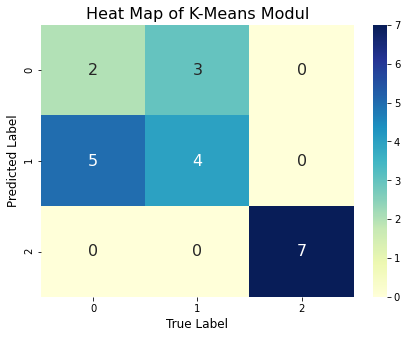

In [81]:
# Import Seaborn library
import seaborn as sns

# Import Python Plot model from Matplotlib library
import matplotlib.pyplot as plt

# Create a heat map to display the crosstab value
ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(ct, cmap="YlGnBu", annot=True, cbar=True, annot_kws={'size':16})
plt.xlabel('True Label', fontsize=12)
plt.ylabel('Predicted Label', fontsize=12)
plt.title('Heat Map of K-Means Modul', fontsize=16)

## Using the Elbow method 
### find the optimal number of clusters

In [82]:
# Print the inertia value to know how well the dataset was clustered by K-Means
print(km.inertia_)

228.29841269841273


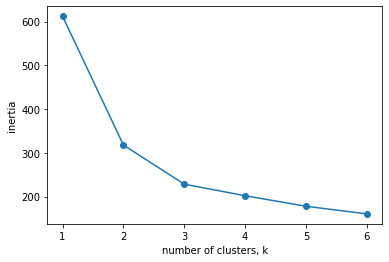

In [83]:
# Assign the range
ks = range(1, 7)

# Create a variable to store a list
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(X_train_70)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [88]:
# Import v_measure_score,accuracy_score,precision_score,recall_score functions
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Fit the model
km.fit(X_train_70, y_train_70)

# Predict the cluster of test dataset
y_pred = km.predict(X_test_30)

# Print V-measure score
# V-measure is the harmonic mean between homogeneity and completeness
print("V-measure score: %.6f" % v_measure_score(km_labels, y_train_70))

# Print accuracy score
print("Accuracy: %.6f" % accuracy_score(y_test_30, y_pred))

# Print precision score
print("Precision: %.6f" % precision_score(y_test_30, y_pred, average='macro'))

# Print recall score
print("Recall: %.6f" % recall_score(y_test_30, y_pred, average='macro'))

V-measure score: 0.593612
Accuracy: 0.888889
Precision: 0.916667
Recall: 0.888889


### 80% training set and 20% test set

In [47]:
# Split the data into training set and test set
# Random state = 42 to get the same random train / test split
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X_cv, y, test_size=0.2, random_state=42)

# Print the length of each sets
print("X_train_80: ", X_train_80.shape)
print("X_test_20: ", X_test_20.shape)
print("y_train_80: ", len(y_train_80))
print("y_test_20: ", len(y_test_20))

X_train_80:  (24, 67)
X_test_20:  (6, 67)
y_train_80:  24
y_test_20:  6


In [48]:
# Convert y_train_80 to list and assign it into labels_train_80
labels_train_80 = y_train_80.tolist()

# Print the content of list
print(labels_train_80)

# Display the length
len(labels_train_80)

[1, 0, 0, 1, 2, 1, 1, 2, 2, 0, 2, 1, 0, 0, 2, 0, 0, 2, 1, 1, 0, 0, 1, 2]


24

In [49]:
# Import KMeans
from sklearn.cluster import KMeans

# Create a KMeans instance with 3 clusters: model
km = KMeans(n_clusters=3)

# Fit model to X_train_80
km.fit(X_train_80)

# Determine the cluster labels of new_points: labels
labels = km.labels_

# Print cluster labels of new_points
print(labels)

# Print the length
len(labels)

[2 0 0 0 1 2 2 1 1 2 1 2 2 2 1 2 0 1 2 0 0 2 0 1]


24

In [50]:
# Use fit_predict functionto fit model and obtain cluster labels: km_labels
km_labels = km.fit_predict(X_train_80)

# Create a DataFrame with labels and varieties as columns: df
df = pd.DataFrame({'km_labels': km_labels, 'dataset_labels': labels_train_80})

# Create crosstab and assign it as ct2 
# To compare resulting cluster labels with user-defined labels
ct2 = pd.crosstab(df['km_labels'], df['dataset_labels'])

# Print the data frame
print(df.to_string())

    km_labels  dataset_labels
0           0               1
1           1               0
2           1               0
3           1               1
4           2               2
5           0               1
6           0               1
7           2               2
8           2               2
9           0               0
10          2               2
11          0               1
12          0               0
13          0               0
14          2               2
15          0               0
16          1               0
17          2               2
18          0               1
19          1               1
20          1               0
21          0               0
22          1               1
23          2               2


In [51]:
# Print crosstab
print(ct2)

dataset_labels  0  1  2
km_labels              
0               5  5  0
1               4  3  0
2               0  0  7


Text(0.5, 1.0, 'Heat Map of K-Means Modul')

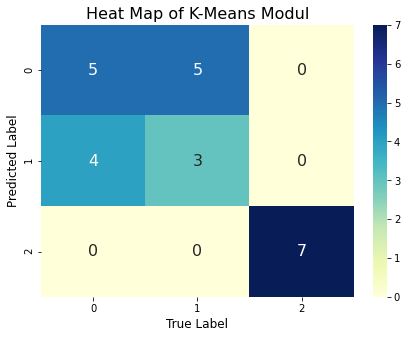

In [52]:
# Import Seaborn library
import seaborn as sns

# Import Python Plot model from Matplotlib library
import matplotlib.pyplot as plt

# Create a heat map to display the crosstab value
ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(ct2, cmap="YlGnBu", annot=True, cbar=True, annot_kws={'size':16})
plt.xlabel('True Label', fontsize=12)
plt.ylabel('Predicted Label', fontsize=12)
plt.title('Heat Map of K-Means Modul', fontsize=16)

In [57]:
# Print the inertia value to know how well the dataset was clustered by K-Means
print(km.inertia_)

276.7285714285714


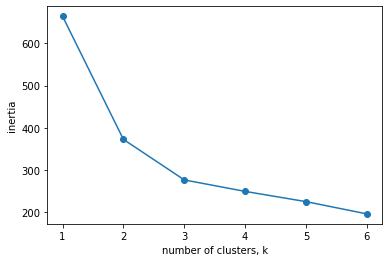

In [58]:
# Assign the range
ks = range(1, 7)

# Create a variable to store a list
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(X_train_80)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [59]:
# Import v_measure_score,accuracy_score,precision_score,recall_score functions
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Fit the model
km.fit(X_train_80, y_train_80)

# Predict the cluster of test dataset
y_pred_20 = km.predict(X_test_20)

# Print V-measure score
print("V-measure score: %.6f" % v_measure_score(km_labels, y_train_80))

# Print accuracy score
print("Accuracy: %.6f" % accuracy_score(y_test_20, y_pred_20))

# Print precision score
print("Precision: %.6f" % precision_score(y_test_20, y_pred_20, average='macro'))

# Print recall score
print("Recall: %.6f" % recall_score(y_test_20, y_pred_20, average='macro'))

V-measure score: 0.556196
Accuracy: 0.500000
Precision: 0.416667
Recall: 0.666667
